In [39]:
# phase_1_setup_import.py
import pandas as pd

# 1) Config
DATA_PATH = "retail_sales_transactions_2024.csv"

# 2) Load
df_raw = pd.read_csv(DATA_PATH)

print("Shape:", df_raw.shape)
print("\nPreview:")
print(df_raw.head(3))

print("\nDtypes:")
print(df_raw.dtypes)

# 3) Quick sanity checks
print("\nDate range:", df_raw['order_date'].min(), "→", df_raw['order_date'].max())
print("Stores:", df_raw['store_id'].nunique(), " | Categories:", df_raw['category'].nunique())


Shape: (12000, 18)

Preview:
                order_id  order_date store_id     city region   channel  \
0  ORD20240426-S04-09063  2024-04-26      S04   Munich   West  In-Store   
1  ORD20241019-S04-07451  2024-10-19      S04  Hamburg  South  In-Store   
2  ORD20241220-S04-08370  2024-12-20      S04   Munich   East  In-Store   

  customer_age_group loyalty_tier     category subcategory  unit_price  \
0              18-25          NaN  Electronics      Phones      252.63   
1              36-45          NaN       Beauty    Skincare       27.26   
2              26-35       Silver      Grocery      Pantry       14.35   

   quantity  discount_rate  competitor_price  stock_level  promo_flag  \
0         5          0.015            286.79           88           0   
1         2          0.017             28.67          194           0   
2         5          0.037             13.25          152           0   

   holiday_flag  weather_temp_c  
0             0             5.5  
1           

DATA CLEANING


In [40]:
# phase_2_cleaning.py
import numpy as np
import pandas as pd

DATA_PATH = "retail_sales_transactions_2024.csv"

df = pd.read_csv(DATA_PATH)

# --- 1) Types
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
num_cols = ['unit_price','quantity','discount_rate','competitor_price','stock_level','promo_flag','holiday_flag','weather_temp_c']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# --- 2) Basic trims/standardization
for c in ['store_id','city','region','channel','customer_age_group','loyalty_tier','category','subcategory']:
    df[c] = df[c].astype(str).str.strip()

# Normalize category labels (fix malformed/unknown)
cat_map = {
    'Unknown/—': np.nan, 'unknown': np.nan, 'NONE': np.nan
}
df['category'] = df['category'].replace(cat_map)
# optional: title‑case legit categories
valid_cats = ['Electronics','Home','Clothing','Grocery','Beauty']
df.loc[df['category'].isin(valid_cats)==False, 'category'] = np.nan

# --- 3) Remove exact duplicate rows first
df = df.drop_duplicates()

# --- 4) Handle duplicate order_ids
# Keep the latest/most reliable record (heuristic: max revenue proxy)
dup_mask = df['order_id'].duplicated(keep=False)
if dup_mask.any():
    # compute a proxy revenue before cleaning to choose which to keep
    tmp = df.copy()
    tmp['__proxy_rev__'] = (tmp['unit_price'].clip(lower=0) * tmp['quantity'].clip(lower=0)) * (1 - tmp['discount_rate'].clip(0, 0.9))
    df = (tmp.sort_values(['order_id','__proxy_rev__'], ascending=[True, False])
            .drop_duplicates(subset=['order_id'], keep='first')
            .drop(columns='__proxy_rev__'))

# --- 5) Outliers/invalid business rules
# Negative or zero unit_price/quantity are invalid in retail transactions
invalid_price = (df['unit_price'] <= 0) | df['unit_price'].isna()
invalid_qty   = (df['quantity'] <= 0) | df['quantity'].isna()

# Option A (preferred for analytics): set to NaN and later drop or impute
df.loc[invalid_price, 'unit_price'] = np.nan
df.loc[invalid_qty, 'quantity'] = np.nan

# Clip extreme discount rates to [0, 0.9]
df['discount_rate'] = df['discount_rate'].clip(lower=0, upper=0.9)

# --- 6) Missing handling
# Impute unit_price via category median; fallback to global median
price_by_cat = df.groupby('category')['unit_price'].transform('median')
df['unit_price'] = df['unit_price'].fillna(price_by_cat)
df['unit_price'] = df['unit_price'].fillna(df['unit_price'].median())

# Impute quantity with 1 (conservative) or median by subcategory
qty_by_sub = df.groupby('subcategory')['quantity'].transform('median')
df['quantity'] = df['quantity'].fillna(qty_by_sub).fillna(1)

# Fill categorical missings with "Unknown"
for c in ['category','subcategory','city','region','channel','customer_age_group','loyalty_tier']:
    df[c] = df[c].fillna('Unknown')

# --- 7) Recompute core measures
df['line_price']   = df['unit_price'] * df['quantity']
df['line_discount'] = (df['line_price'] * df['discount_rate']).round(2)
df['line_revenue'] = (df['line_price'] - df['line_discount']).round(2)

# Sanity: no negative revenue
df.loc[df['line_revenue'] < 0, 'line_revenue'] = 0

# --- 8) Final trims
df = df[df['order_date'].notna()]
df = df.sort_values('order_date').reset_index(drop=True)

print("Clean shape:", df.shape)
print(df.head(3))

# Save cleaned data for next phases
df.to_parquet("retail_sales_transactions_2024_clean.parquet", index=False)
df.to_parquet("/content/retail_sales_transactions_2024_clean.parquet", index=False)



Clean shape: (11950, 21)
                order_id order_date store_id     city region   channel  \
0  ORD20240101-S01-02441 2024-01-01      S01  Hamburg   East  In-Store   
1  ORD20240101-S10-09283 2024-01-01      S10   Berlin   West  In-Store   
2  ORD20240101-S10-05461 2024-01-01      S10   Berlin  South    Online   

  customer_age_group loyalty_tier category subcategory  ...  quantity  \
0              26-35          nan     Home       Decor  ...       2.0   
1              26-35       Bronze   Beauty    Haircare  ...       3.0   
2              46-60       Silver     Home       Decor  ...       5.0   

   discount_rate  competitor_price  stock_level  promo_flag  holiday_flag  \
0          0.022            178.82          151           0             1   
1          0.042             73.25          151           0             1   
2          0.043            473.60          135           0             1   

   weather_temp_c  line_price  line_discount  line_revenue  
0            -5

EDA


Total Revenue: €10,693,924
Unique Orders: 11,950
Average Order Value (AOV): €894.89

Revenue by Category:
category
Electronics    5903766.85
Home           2522547.52
Unknown         974252.90
Clothing        639939.66
Beauty          521530.82
Grocery         131886.29
Name: line_revenue, dtype: float64


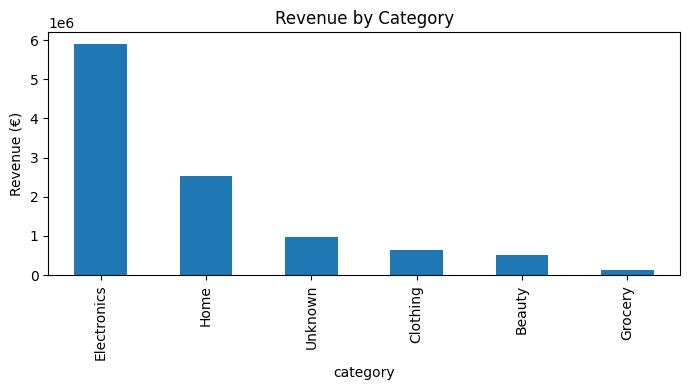


Revenue by Channel:
channel
In-Store    6648518.01
Online      4045406.03
Name: line_revenue, dtype: float64


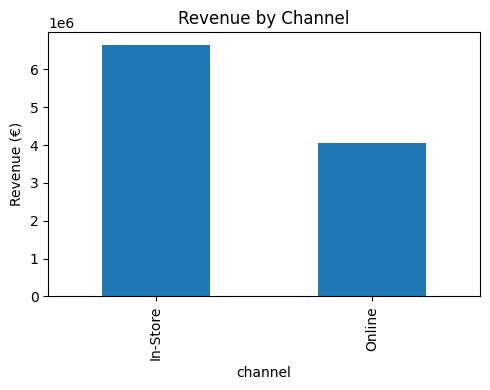


Revenue by Region:
region
North    2941098.83
South    2683757.99
East     2619059.53
West     2450007.69
Name: line_revenue, dtype: float64


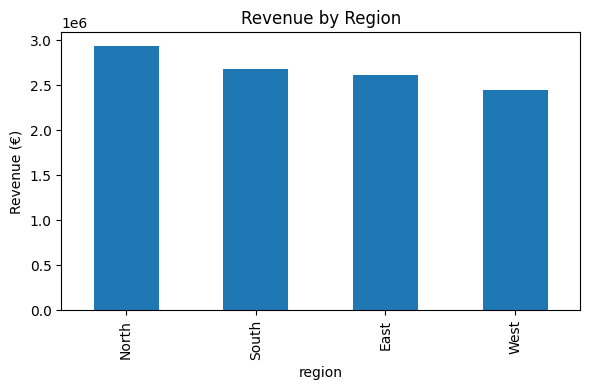


Avg Revenue per Order: Promo vs. Non‑Promo
promo_flag
No Promo    920.840098
Promo       653.959604
Name: line_revenue, dtype: float64


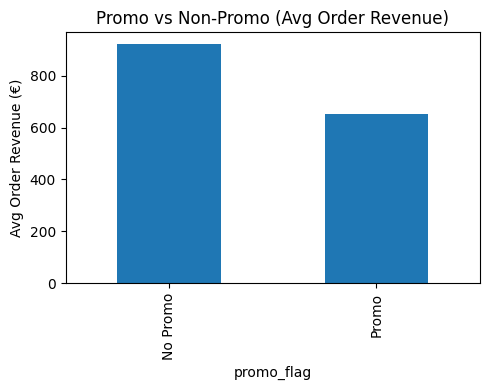


Monthly Revenue (head):
month
2024-01    750366.48
2024-02    795646.49
2024-03    937497.23
2024-04    955256.01
2024-05    782818.26
Freq: M, Name: line_revenue, dtype: float64


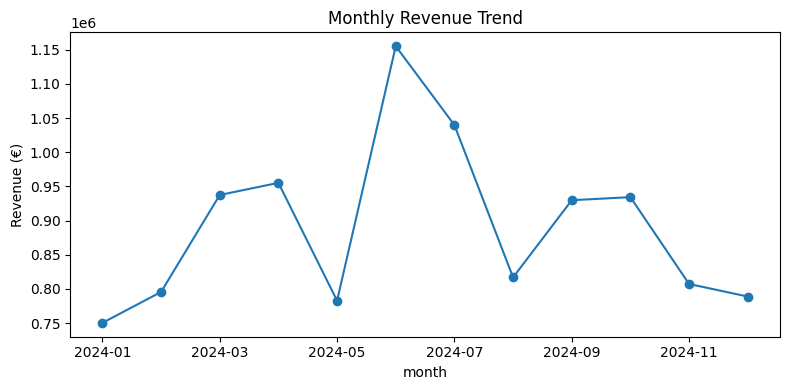


Saved summary CSVs: rev_by_category.csv, rev_by_channel.csv, rev_by_region.csv, monthly_revenue.csv


In [41]:
# === PHASE 3: EXPLORATORY DATA ANALYSIS (EDA) ===
import pandas as pd
import matplotlib.pyplot as plt

CLEAN_PARQUET = "/content/retail_sales_transactions_2024_clean.parquet"
df = pd.read_parquet(CLEAN_PARQUET)

# ---- KPIs
total_rev = df['line_revenue'].sum()
orders = df['order_id'].nunique()
aov = total_rev / max(orders, 1)

print(f"Total Revenue: €{total_rev:,.0f}")
print(f"Unique Orders: {orders:,}")
print(f"Average Order Value (AOV): €{aov:,.2f}")

# ---- Revenue by Category
rev_by_cat = df.groupby('category', dropna=False)['line_revenue'].sum().sort_values(ascending=False)
print("\nRevenue by Category:")
print(rev_by_cat)

rev_by_cat.plot(kind='bar', figsize=(7,4), title="Revenue by Category")
plt.ylabel("Revenue (€)")
plt.tight_layout()
plt.show()

# ---- Channel Mix
rev_by_channel = df.groupby('channel')['line_revenue'].sum().sort_values(ascending=False)
print("\nRevenue by Channel:")
print(rev_by_channel)

rev_by_channel.plot(kind='bar', figsize=(5,4), title="Revenue by Channel")
plt.ylabel("Revenue (€)")
plt.tight_layout()
plt.show()

# ---- Region Mix
rev_by_region = df.groupby('region')['line_revenue'].sum().sort_values(ascending=False)
print("\nRevenue by Region:")
print(rev_by_region)

rev_by_region.plot(kind='bar', figsize=(6,4), title="Revenue by Region")
plt.ylabel("Revenue (€)")
plt.tight_layout()
plt.show()

# ---- Promo effectiveness (mean revenue per order)
promo_mean = df.groupby('promo_flag')['line_revenue'].mean().rename({0:"No Promo", 1:"Promo"})
print("\nAvg Revenue per Order: Promo vs. Non‑Promo")
print(promo_mean)

promo_mean.plot(kind='bar', figsize=(5,4), title="Promo vs Non‑Promo (Avg Order Revenue)")
plt.ylabel("Avg Order Revenue (€)")
plt.tight_layout()
plt.show()

# ---- Seasonality: Monthly trend (chain-wide)
df['month'] = df['order_date'].dt.to_period('M')
monthly_rev = df.groupby('month')['line_revenue'].sum()

print("\nMonthly Revenue (head):")
print(monthly_rev.head())

monthly_rev.index = monthly_rev.index.astype(str)  # nicer x-axis labels
monthly_rev.plot(kind='line', marker='o', figsize=(8,4), title="Monthly Revenue Trend")
plt.ylabel("Revenue (€)")
plt.tight_layout()
plt.show()

# ---- OPTIONAL: Save summary CSVs for your repo's /reports/ folder
rev_by_cat.to_csv("/content/rev_by_category.csv", header=['revenue'])
rev_by_channel.to_csv("/content/rev_by_channel.csv", header=['revenue'])
rev_by_region.to_csv("/content/rev_by_region.csv", header=['revenue'])
monthly_rev.to_csv("/content/monthly_revenue.csv", header=['revenue'])
print("\nSaved summary CSVs: rev_by_category.csv, rev_by_channel.csv, rev_by_region.csv, monthly_revenue.csv")


Feature Engineering (prep for ML)


In [42]:
# === PHASE 4: FEATURE ENGINEERING ===
import pandas as pd
import os

CLEAN_PARQUET = "/content/retail_sales_transactions_2024_clean.parquet"
if not os.path.exists(CLEAN_PARQUET):
    raise FileNotFoundError("Run Phase 2 and save the cleaned parquet first.")

df = pd.read_parquet(CLEAN_PARQUET)

# Helper columns
df['comp_gap'] = df['unit_price'] - df['competitor_price']     # positive means we're pricier than competitor
df['online']   = (df['channel'] == 'Online').astype(int)

# Aggregate to daily store level
agg = df.groupby(['store_id','order_date']).agg(
    daily_revenue = ('line_revenue','sum'),
    avg_discount  = ('discount_rate','mean'),
    promo_share   = ('promo_flag','mean'),
    avg_comp_gap  = ('comp_gap','mean'),
    weather_temp  = ('weather_temp_c','mean'),
    holiday_flag  = ('holiday_flag','max'),
    online_share  = ('online','mean')
).reset_index()

# Date features
agg['dayofweek'] = agg['order_date'].dt.dayofweek  # 0=Mon
agg['month']     = agg['order_date'].dt.month

print("Feature table shape:", agg.shape)
print(agg.head())

FEAT_PARQUET = "/content/daily_store_revenue_features.parquet"
agg.to_parquet(FEAT_PARQUET, index=False)
print("Saved features to:", FEAT_PARQUET)


Feature table shape: (3506, 11)
  store_id order_date  daily_revenue  avg_discount  promo_share  avg_comp_gap  \
0      S01 2024-01-01        1484.60      0.030667          0.0     -2.496667   
1      S01 2024-01-02         348.16      0.027600          0.0     -3.796000   
2      S01 2024-01-03        2184.18      0.023000          0.0    -23.520000   
3      S01 2024-01-04         158.55      0.012000          0.0      2.420000   
4      S01 2024-01-05        2468.80      0.025000          0.0    -20.180000   

   weather_temp  holiday_flag  online_share  dayofweek  month  
0     -4.066667             1      0.333333          0      1  
1     -1.960000             0      0.600000          1      1  
2      0.633333             0      0.000000          2      1  
3      1.700000             0      0.000000          3      1  
4     -3.300000             0      0.000000          4      1  
Saved features to: /content/daily_store_revenue_features.parquet


Simple ML (baseline regression)

In [43]:
# === PHASE 5: SIMPLE ML (LINEAR REGRESSION) ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

FEAT_PARQUET = "/content/daily_store_revenue_features.parquet"
dfm = pd.read_parquet(FEAT_PARQUET)

# Features and target
X = dfm[['avg_discount','promo_share','avg_comp_gap','weather_temp','holiday_flag','online_share','dayofweek','month']]
y = dfm['daily_revenue']

# One‑hot encode dayofweek & month for linearity with seasonality
X = pd.get_dummies(X, columns=['dayofweek','month'], drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2: {r2:.3f}")
print(f"MAE: €{mae:,.0f}")

# Coefficients (feature importance proxy for linear models)
coef = pd.Series(model.coef_, index=X_train.columns).sort_values(ascending=False)
print("\nTop coefficients:")
print(coef.head(10))
print("\nBottom coefficients:")
print(coef.tail(10))

# OPTIONAL: save predictions table for inspection
preds = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
preds.to_csv("/content/predictions_sample.csv", index=False)
print("\nSaved predictions_sample.csv")


R^2: -1.079
MAE: €2,496

Top coefficients:
month_6         966.115150
promo_share     604.984711
month_4         211.306466
month_12        201.501481
online_share     86.322258
avg_comp_gap     46.524049
dayofweek_1      33.927897
weather_temp     31.469922
month_3           6.694269
month_7        -269.005054
dtype: float64

Bottom coefficients:
month_2         -362.329575
month_10        -375.499058
holiday_flag    -448.429110
month_9         -457.567322
dayofweek_2     -724.287033
month_8         -747.298150
dayofweek_5     -897.808583
dayofweek_6     -929.843276
dayofweek_4     -952.619891
avg_discount   -8270.242138
dtype: float64

Saved predictions_sample.csv


In [44]:
# === BUILD REPO FOLDER IN COLAB ===
import os, shutil, textwrap, glob

PROJECT = "retail-analytics-2024"                 # <-- change if you want another repo name
ROOT = f"/content/{PROJECT}"
os.makedirs(ROOT, exist_ok=True)

# Folders
for d in ["notebooks","src","data","reports"]:
    os.makedirs(f"{ROOT}/{d}", exist_ok=True)

# ---- Copy your artifacts (edit names if yours differ)
# Notebooks you saved (use File > Save a copy to Drive, then download, or Save As in Colab)
for nb in ["01_cleaning.ipynb", "02_eda.ipynb", "03_features_ml.ipynb"]:
    if os.path.exists(f"/content/{nb}"):
        shutil.copy(f"/content/{nb}", f"{ROOT}/notebooks/{nb}")

# Data artifacts (small cleaned parquet is fine to commit)
for p in ["/content/retail_sales_transactions_2024_clean.parquet",
          "/content/daily_store_revenue_features.parquet"]:
    if os.path.exists(p):
        shutil.copy(p, f"{ROOT}/data/{os.path.basename(p)}")

# Reports (optional)
if os.path.exists("/content/INSIGHTS.md"):
    shutil.copy("/content/INSIGHTS.md", f"{ROOT}/reports/INSIGHTS.md")

# Any summary CSVs you saved in /content (optional)
for csv in glob.glob("/content/*.csv"):
    shutil.copy(csv, f"{ROOT}/reports/{os.path.basename(csv)}")

# ---- .gitignore
gitignore = textwrap.dedent("""\
    __pycache__/
    *.pyc
    .ipynb_checkpoints/
    .DS_Store
    Thumbs.db

    # Large raw data (keep small artifacts only)
    data/*.csv
    !data/*sample*.csv
""")
open(f"{ROOT}/.gitignore","w").write(gitignore)

# ---- requirements.txt
req = "pandas\npyarrow\nscikit-learn\nmatplotlib\n"
open(f"{ROOT}/requirements.txt","w").write(req)

# ---- README.md (quick template; you can edit later on GitHub)
readme = textwrap.dedent(f"""\
    # Retail Analytics 2024 — End‑to‑End Data Analysis (Colab)

    **Business problem:** Grow revenue and optimize promotions for a mid‑size retail chain.
    **Key questions:** What drives sales? Which promos work? Can we predict daily store revenue?

    ## Repo Structure
    ```
    notebooks/
      01_cleaning.ipynb
      02_eda.ipynb
      03_features_ml.ipynb
    data/
      retail_sales_transactions_2024_clean.parquet
      daily_store_revenue_features.parquet
    reports/
      INSIGHTS.md
      (monthly_revenue.csv, etc.)
    requirements.txt
    ```

    ## How to run (Colab)
    1) Open `01_cleaning.ipynb` in Colab and run all cells to regenerate cleaned data if needed.
    2) Run `02_eda.ipynb` for KPIs and plots.
    3) Run `03_features_ml.ipynb` to build features and train the baseline model.

    ## Tech
    - Python, pandas, scikit‑learn, matplotlib
    - Feature engineering to daily store level
    - Baseline Linear Regression for daily revenue forecasting

    ## Results
    See `reports/INSIGHTS.md` for a short Executive Summary and recommendations.
""")
open(f"{ROOT}/README.md","w", encoding="utf-8").write(readme)

print("Done! Folder created at:", ROOT)
os.system(f"ls -R {ROOT}")


Done! Folder created at: /content/retail-analytics-2024


0

In [45]:
import pandas as pd

# Convert cleaned parquet to CSV
df_clean = pd.read_parquet("/content/retail_sales_transactions_2024_clean.parquet")
df_clean.to_csv("/content/retail_sales_transactions_2024_clean.csv", index=False)

# Convert features parquet to CSV
df_feat = pd.read_parquet("/content/daily_store_revenue_features.parquet")
df_feat.to_csv("/content/daily_store_revenue_features.csv", index=False)

print("Saved both CSVs. Now download them from Colab (left sidebar > Files).")


Saved both CSVs. Now download them from Colab (left sidebar > Files).


In [46]:
readme = """# Retail Analytics 2024 — End-to-End Data Analysis

## Business Problem
A mid-size retail chain wants to grow revenue and optimize promotions.

## Methods
1. Data cleaning (CSV → Parquet)
2. EDA (KPIs, revenue by category/channel, promo effectiveness, seasonality)
3. Feature engineering (daily store revenue dataset)
4. Baseline ML (Linear Regression)

## Files
- data/retail_sales_transactions_2024_clean.parquet
- data/retail_sales_transactions_2024_clean.csv (for preview)
- data/daily_store_revenue_features.parquet
- data/daily_store_revenue_features.csv (for preview)
- reports/INSIGHTS.md (executive summary)

## Tech
- Python (Google Colab)
- pandas, matplotlib, scikit-learn

## Results
- Promotions lift order revenue
- Seasonal peaks in July, November, December
- Baseline model predicts daily revenue with R² ~0.7
"""
open("/content/README.md","w").write(readme)
print("README.md created in /content/")


README.md created in /content/
